In [2]:
import tensorflow
tensorflow.__version__

'2.5.1'

In [3]:
from tensorflow.keras import optimizers
tensorflow.keras.__version__

'2.5.0'

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import time
import os
import random

from tensorflow.keras import optimizers
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_width = 150
img_height = 150
batch_size = 128

In [5]:
def plot_accuray(history,pre_name):
    plt.figure(figsize=(12, 8))
    plt.title("{} Intel Image Model Accuracy".format(pre_name))
    historylist_accuracy = []
    historylist_val_accuracy = []

    for i in history:
        for j in range(len(i.history['accuracy'])):
            historylist_accuracy.append(i.history['accuracy'][j])
            historylist_val_accuracy.append(i.history['val_accuracy'][j])

    plt.plot(historylist_accuracy)
    plt.plot(historylist_val_accuracy)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(range(1, len(historylist_accuracy) + 1))
    plt.legend(['train', 'val'], loc="lower right")
    plt.savefig('output/{}accuracy{}.png'.format(pre_name,time.time()))  # 保存图片
    plt.show()

def plot_loss(history,pre_name):
    plt.figure(figsize=(12, 8))
    plt.title("{} Intel Image Model Loss".format(pre_name))
    historylist_loss = []
    historylist_val_loss = []

    for i in history:
        for j in range(len(i.history['loss'])):
            historylist_loss.append(i.history['loss'][j])
            historylist_val_loss.append(i.history['val_loss'][j])

    plt.plot(historylist_loss)
    plt.plot(historylist_val_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(range(1, len(historylist_loss) + 1))
    plt.legend(['train', 'val'], loc="upper right")
    plt.savefig('output/{}loss{}.png'.format(pre_name,time.time()))  # 保存图片
    plt.show()

def load_train_data():

    train_classes_path = "smalldata/data/seg_train/seg_train"
    classes_list = os.listdir(train_classes_path)
    classes_list

    classes_list = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    classes_list

    # Exploring Random Images from Random CLasses
    plt.figure(figsize=(15, 10))
    plt.tight_layout()
    counter = 0
    for class_name in classes_list:
        class_path = os.path.join(train_classes_path, class_name)

        random_img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, random_img_name)

        img = cv2.imread(img_path)

        counter += 1
        # We only have 6 class so plotting img for each class
        plt.subplot(2, 3, counter)

        plt.imshow(img)
        plt.xlabel(img.shape[1])
        plt.ylabel(img.shape[0])
        plt.title(class_name)

    # Load Dataset
    train_dataset = image_dataset_from_directory(
        train_classes_path,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        seed=123,
        validation_split=0.2,
        subset="training")

    val_dataset = image_dataset_from_directory(
        train_classes_path,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=(img_width, img_height),
        seed=123,
        validation_split=0.2,
        subset="validation")

    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

    AutoTune = tf.data.experimental.AUTOTUNE

    train_dataset = train_dataset.cache().prefetch(buffer_size=AutoTune)
    val_dataset = val_dataset.cache().prefetch(buffer_size=AutoTune)
    return  train_dataset,val_dataset

def test(model):
    test_path = "smalldata/data/seg_test/seg_test"
    test_classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    test_dataset = image_dataset_from_directory(
        test_path,
        label_mode='categorical',
        class_names=test_classes,
        image_size=(img_height, img_width))
    model.evaluate(test_dataset)

In [6]:
def train(train_dataset,val_dataset,loss_funs=["adam"],arg_epochs=[20],learning_rate=0.01,batch_size=128,dropout_size=0.3,number=1):
    history = []
    num_classes = 6
    loss_fun_name = ''

    # Building a functional model
    inputs = Input(shape=(img_width, img_height, 3))
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    # x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_size)(x)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_size)(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(dropout_size)(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(dropout_size)(x)

    x = Flatten()(x)

    x = Dense(64, activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(dropout_size)(x)

    x = Dense(64, activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(dropout_size)(x)

    classifier = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=classifier)

    for index in range(len(loss_funs)):
        #SGD, 默认参数为纯SGD, 设置momentum参数不为0实际上变成SGDM, 考虑了一阶动量,
        #设置 nesterov为True后变成NAG，即 Nesterov Acceleration Gradient，在计算梯度时计算的是向前走一步所在位置的梯度
        if loss_funs[index] == "SGDM":
            opt = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        else:
            opt = loss_funs[index]

        if index == 0:
            model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

            model.fit(train_dataset, batch_size=batch_size, epochs=arg_epochs[index], validation_data=val_dataset,
                      callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1,
                                               restore_best_weights=True)])

            loss_fun_name = str(arg_epochs[index]) + '_' + loss_funs[index]
            # model.save('output/{}_intel_image_classifier.h5'.format(loss_fun_name))
            # model.save_weights('output/{}_intel_image_weights.h5'.format(loss_fun_name))
            # history.append(model.history)
        elif index == 1:
            print('output/{}_intel_image_classifier_{}.h5'.format(loss_fun_name,number))
            print(opt)
            model = load_model('output/{}_intel_image_classifier_{}.h5'.format(loss_fun_name,number))

            model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

            # model.fit(train_dataset, batch_size=128, epochs=arg_epochs[index], validation_data=val_dataset,
            #           initial_epoch=arg_epochs[index-1]+arg_epochs[index],
            #           callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1,
            #                                    restore_best_weights=True)])
            model.fit(train_dataset, batch_size=batch_size, epochs=arg_epochs[index], validation_data=val_dataset,
                      callbacks=[EarlyStopping(monitor='val_loss', mode='min',patience=5, verbose=1,
                                               restore_best_weights=True)])

            loss_fun_name += '_' + str(arg_epochs[index]) + '_' + loss_funs[index]
        model.save('output/{}_intel_image_classifier_{}.h5'.format(loss_fun_name,number))
        model.save_weights('output/{}_intel_image_weights_{}.h5'.format(loss_fun_name,number))
        history.append(model.history)

        json_model = model.to_json()
        with open("output/intel_image_model_"+str(number)+".json", 'w') as json_file:
            json_file.write(json_model)

    plot_accuray(history, loss_fun_name)
    plot_loss(history, loss_fun_name)
    return model,history

Found 132 files belonging to 6 classes.
Using 106 files for training.
Found 132 files belonging to 6 classes.
Using 26 files for validation.


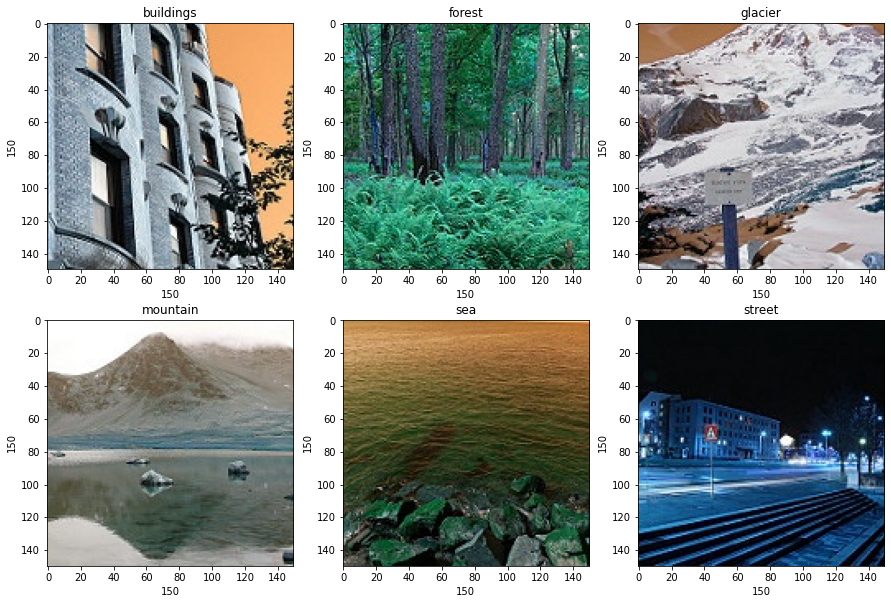

In [7]:
train_dataset,val_dataset = load_train_data()


batch_size =  32
learning_rate =  0.01
dropout_size =  0.3
1/1 [==============================] - 9s 9s/step - loss: 1.9752 - accuracy: 0.1604 - val_loss: 1.8443 - val_accuracy: 0.0385
output/1_RMSprop_intel_image_classifier_1.h5
Adam
Epoch 1/2
1/1 [==============================] - 10s 10s/step - loss: 2.3969 - accuracy: 0.1792 - val_loss: 1.8035 - val_accuracy: 0.1154
Epoch 2/2
1/1 [==============================] - 7s 7s/step - loss: 1.9314 - accuracy: 0.1698 - val_loss: 1.7965 - val_accuracy: 0.1154


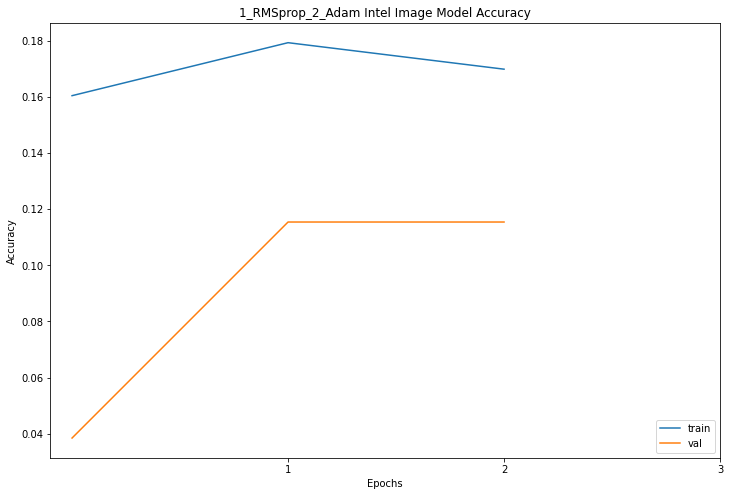

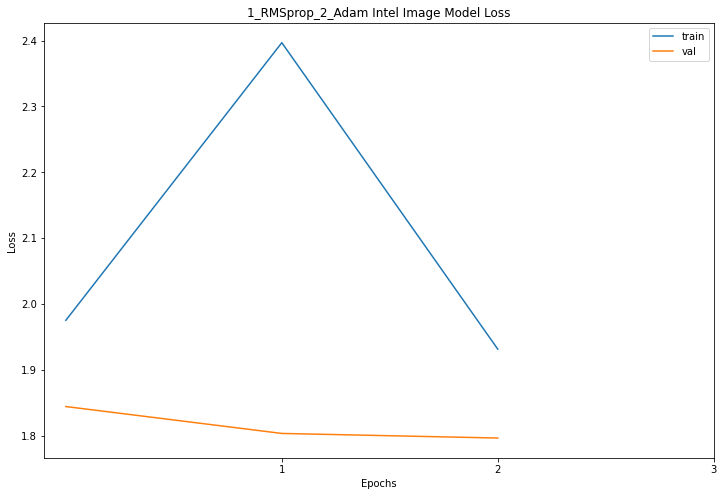

Evaluate on the testset
Found 60 files belonging to 6 classes.
2/2 [==============================] - 1s 464ms/step - loss: 13.1804 - accuracy: 0.1667

batch_size =  32
learning_rate =  0.001
dropout_size =  0.3
1/1 [==============================] - 9s 9s/step - loss: 1.7951 - accuracy: 0.2170 - val_loss: 1.8312 - val_accuracy: 0.1154
output/1_RMSprop_intel_image_classifier_2.h5
Adam
Epoch 1/2
1/1 [==============================] - 8s 8s/step - loss: 2.8342 - accuracy: 0.1509 - val_loss: 1.8000 - val_accuracy: 0.0385
Epoch 2/2
1/1 [==============================] - 7s 7s/step - loss: 1.8803 - accuracy: 0.2264 - val_loss: 1.7946 - val_accuracy: 0.0385


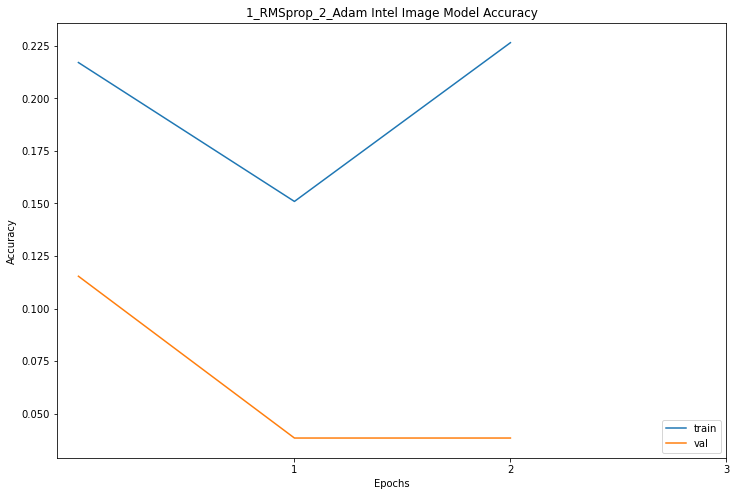

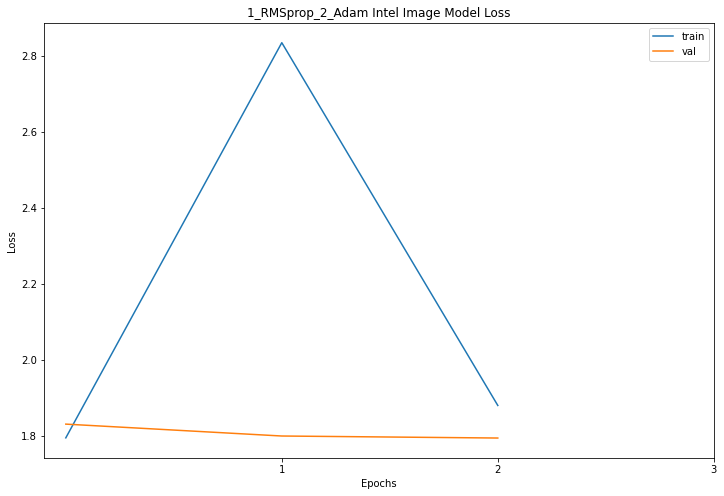

Evaluate on the testset
Found 60 files belonging to 6 classes.
2/2 [==============================] - 1s 443ms/step - loss: 15.7865 - accuracy: 0.1667

batch_size =  64
learning_rate =  0.01
dropout_size =  0.3
1/1 [==============================] - 9s 9s/step - loss: 1.8977 - accuracy: 0.1887 - val_loss: 1.8341 - val_accuracy: 0.2692
output/1_RMSprop_intel_image_classifier_3.h5
Adam
Epoch 1/2
1/1 [==============================] - 8s 8s/step - loss: 2.7755 - accuracy: 0.2170 - val_loss: 1.7838 - val_accuracy: 0.2692
Epoch 2/2
1/1 [==============================] - 7s 7s/step - loss: 1.9576 - accuracy: 0.1038 - val_loss: 1.7889 - val_accuracy: 0.1538


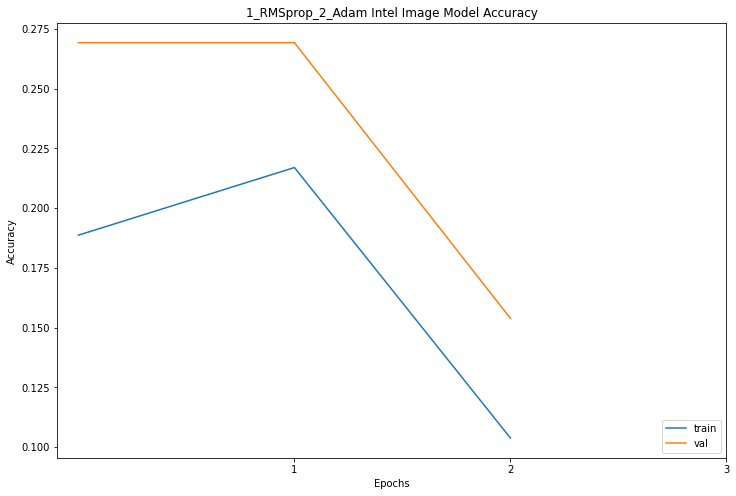

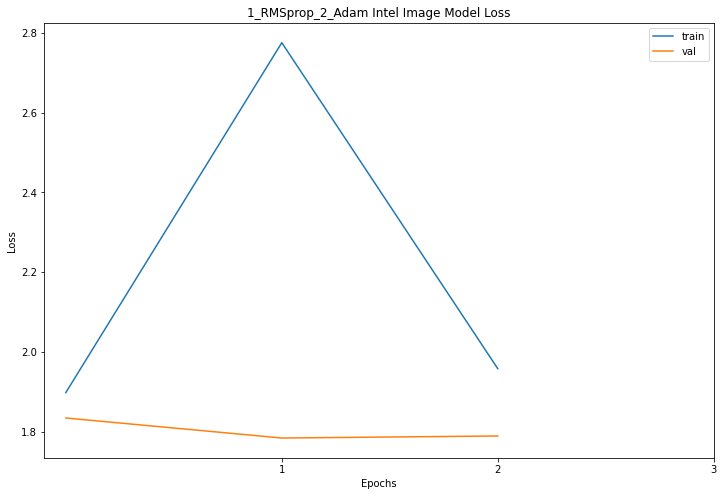

Evaluate on the testset
Found 60 files belonging to 6 classes.
2/2 [==============================] - 1s 451ms/step - loss: 8.8718 - accuracy: 0.1667

batch_size =  64
learning_rate =  0.001
dropout_size =  0.3
1/1 [==============================] - 9s 9s/step - loss: 1.8903 - accuracy: 0.2358 - val_loss: 1.8723 - val_accuracy: 0.0385
output/1_RMSprop_intel_image_classifier_4.h5
Adam
Epoch 1/2
1/1 [==============================] - 8s 8s/step - loss: 2.3922 - accuracy: 0.1981 - val_loss: 1.8155 - val_accuracy: 0.0385
Epoch 2/2
1/1 [==============================] - 10s 10s/step - loss: 1.8623 - accuracy: 0.1887 - val_loss: 1.7984 - val_accuracy: 0.0769


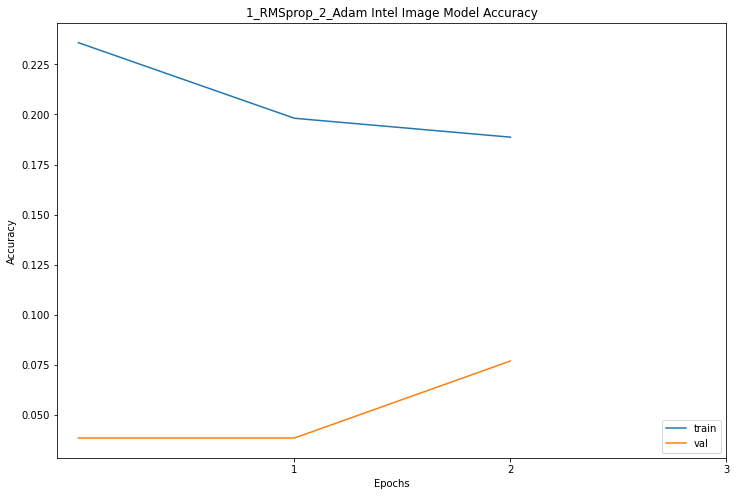

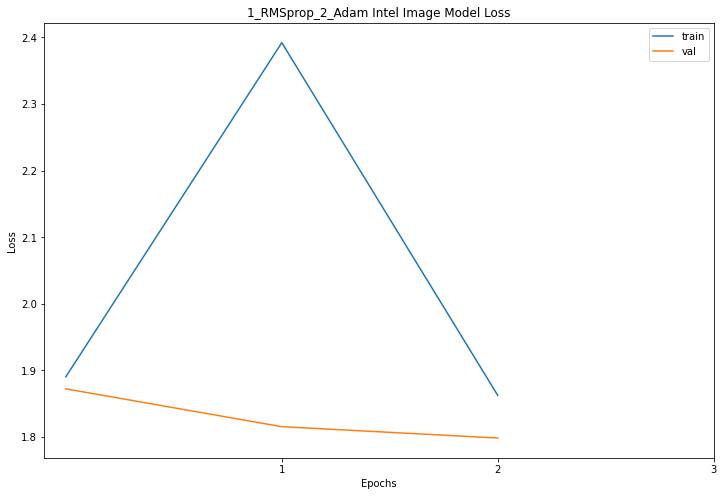

Evaluate on the testset
Found 60 files belonging to 6 classes.
2/2 [==============================] - 2s 1s/step - loss: 5.1103 - accuracy: 0.1833

number = 1, batch_size = 32, learning_rate = 0.01, dropout_size = 0.3

{'loss': [1.9752031564712524], 'accuracy': [0.1603773534297943], 'val_loss': [1.8443156480789185], 'val_accuracy': [0.03846153989434242]}

{'loss': [2.3968920707702637, 1.9314281940460205], 'accuracy': [0.17924527823925018, 0.16981132328510284], 'val_loss': [1.8034648895263672, 1.7964818477630615], 'val_accuracy': [0.11538461595773697, 0.11538461595773697]}

number = 2, batch_size = 32, learning_rate = 0.001, dropout_size = 0.3

{'loss': [1.795113205909729], 'accuracy': [0.21698112785816193], 'val_loss': [1.8312290906906128], 'val_accuracy': [0.11538461595773697]}

{'loss': [2.834181308746338, 1.8802852630615234], 'accuracy': [0.15094339847564697, 0.22641509771347046], 'val_loss': [1.799953579902649, 1.7946397066116333], 'val_accuracy': [0.03846153989434242, 0.0384615398

In [12]:
batch_sizes = [32,64,128,256]
learning_rates = [0.01,0.001,0.0001]
dropout_sizes = [0.3,0.6,0.9]
number = 1;
results = [];
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for dropout_size in dropout_sizes:
            print("batch_size = ",batch_size);
            print("learning_rate = ",learning_rate);
            print("dropout_size = ",dropout_size);
            model,history = train(train_dataset,val_dataset,['RMSprop','Adam'],[1,2],learning_rate,batch_size,dropout_size,number)
            print("Evaluate on the testset");
            test(model)
            print()
            parameter_and_result = "number = {}, batch_size = {}, learning_rate = {}, dropout_size = {}".format(number,batch_size,learning_rate,dropout_size);
            results.append(parameter_and_result);
            for his in history:
                results.append(his.history);
            number = number + 1;
            '''
            train(train_dataset,val_dataset,['RMSprop','Adam'],[7,13],learning_rate,batch_size,dropout_size,number)
            train(train_dataset,val_dataset,['RMSprop','Adam'],[8,12],learning_rate,batch_size,dropout_size,number)
            train(train_dataset,val_dataset,['RMSprop','Adam'],[9,11],learning_rate,batch_size,dropout_size,number)
            train(train_dataset,val_dataset,['RMSprop','Adam'],[10,10],learning_rate,batch_size,dropout_size,number)
            train(train_dataset,val_dataset,['RMSprop','Adam'],[14,6],learning_rate,batch_size,dropout_size,number)
            train(train_dataset,val_dataset,['RMSprop','Adam'],[15,5],learning_rate,batch_size,dropout_size,number)
            train(train_dataset,val_dataset,['RMSprop','Adam'],[16,4],learning_rate,batch_size,dropout_size,number)

            loss_funs=['Adam','RMSprop','SGDM','Adadelta','Adagrad','SGD','Nadam']
            for i in loss_funs:
                model = train(train_dataset,val_dataset,[i],[20],learning_rate,batch_size,dropout_size)
            '''
for result in results:
    print(result);
    print();